# Policy Gradient in Reinforcement Learning

As we saw in the [previous tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb), Q-Learning is a baseline method for optimizing generic RL problems, but a lot of real problems involve stochastic environments, such as the continuous space, and this straight-forward method discussed in [previous tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb) will suffer from these gaps.<br>
In order to overcome, the stochastic distributions are introduced in recent algorithms. For instance, you will be able to use categorical distribution in discrete action spaces, and Gaussian distribution for even ```Box``` (continuos) action spaces.

This tutorial shows the idea of on-policy learning using simple program code.

> Note : Here I'll show you vanilla (plane) policy gradient architecture for your introduction, but most algorithms with policy gradient involves advanced other tricks in practice. (See Actor-Critic or PPO examples.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.<br>
Here we use TensroFlow in order to operate gradient descent.

In [ ]:
!pip install numpy gym keras tensorflow==2.4 matplotlib

In [1]:
import gym
import numpy as np
import tensorflow as tf

In policy gradient, the action $a$ is picked up by the distribution $P$ which depends on policy $\pi$.<br>
To say more clearly, the distibution of action is $ P(a | \pi_\theta (s)) $ (which depends on the current state $s$), where $ \pi_\theta (s) $ is policy and $\theta$ is parameters for policy.

In this example, $P(\cdot)$ is categorical distribution (because action space is discrete in this example), and $\pi_\theta (s)$ is the following fcnet (fully-connected) network model ```policy_pi```, in which ```s_input``` is observation state input. ($ \theta $ is then parameters of this fcnet model.)<br>
The output of $\pi_\theta (s)$ (i.e, ```policy_pi```) is logits value for determining categorical distribution $P(\cdot)$.

![policy](assets/policy.png?raw=true)

> Note : Here I assume "logits" instead of "probability", but when you use "probability" instead, please specify ```softmax``` as activation in final layer.

In [2]:
s_input = tf.keras.layers.Input(shape=(4, ))
hidden = tf.keras.layers.Dense(64,activation='relu')(s_input)
a_output = tf.keras.layers.Dense(2,activation=None)(hidden)

policy_pi = tf.keras.Model([s_input], [a_output])

In each episode, we consider the following expectation $E_{\pi_\theta}[R]$.
$$ E_{\pi_\theta}[R]=\int_a{R(a) \cdot P(a|\pi_\theta(s))} $$
where $R$ is the cumulative expected rewards $ R = \sum{\gamma r} $, and $\gamma$ is discount rate. (See [Q-Learning](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb) for $ \sum{\gamma r} $.)

> Note : To simplify, here I used $ \int_a R P $, but consider $ \int_{\tau} R P $ for any trajectory $ \tau $.

To get the optimimal $ \theta $ which maximizes $E$, we apply the gradient descent $ \theta_{t+1} \leftarrow \theta_t + \Delta \theta $<br>
where
$$ \Delta \theta = \alpha R \cdot \nabla_{\theta} \log{P(a|\pi_\theta(s))} \;\;\;\;\; (1) $$
and $\alpha$ is learning rate.

<blockquote>
Note : Here I don't go so far, but this formula is derived from the following equation. It's difficult to know $ \nabla E $ directly, but this formula can be easily used on each step in gradient algorithms.

$$ \nabla_{\theta} \int{R(a) \cdot P(a|\pi_\theta(s))} = \int{R(a) \nabla_{\theta}{\log P(a|\pi_\theta(s))} \cdot P(a|\pi_\theta(s))} $$
</blockquote>

As you can see in the equation (1), if the expected reward $R$ is positively large, the probability to take action $a$ in the state $s$ will be increased by modifying $\theta$. On contrary, if the expected reward $R$ is negative, $\theta$ will be changed to decrease the probability to take this action $a$.

As you find, this algorithm will improve a stochastic policy by action's policy $ P( \cdot | \pi_\theta (s)) $ updates, not only depending on greedy action sampling (i.e, experiences) such as used in [Q-learning](./01-q-learning.ipynb). This method is then sometimes called **on-policy** learning.<br>
(I'll introduce another approach to operate continuos action by off-policy way in "[DDPG](./05-ddpg.ipynb)".)

To implement this optimization, the training script will become as follows.

> Note : The negative value of this log probability is known as the value of cross-entropy error in categorical distribution.<br>
> Here I then used ```-tf.nn.sparse_softmax_cross_entropy_with_logits()``` to get log probability ($ \log P $) in the following code.

In [3]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    logits = policy_pi(tf.cast(np.array([s]), tf.float32))
    # return tf.Tensor([[a]], shape=(1, 1), dtype=int64)
    a_tensor = tf.random.categorical(logits, 1)
    # return tf.Tensor([a], shape=(1, 1), dtype=int64)
    a_tensor = tf.squeeze(a_tensor, axis=1)
    # return a
    return int(a_tensor.numpy()[0])

env = gym.make("CartPole-v0")
reward_records = []
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(600):
    # Run episode till done
    done = False
    states_arr = []
    action_arr = []
    reward_arr = []
    s = env.reset()
    while not done:
        states_arr.append(s)
        a = pick_sample(s)
        s, r, done, _ = env.step(a)
        action_arr.append(a)
        reward_arr.append(r)

    # Change to cumulative rewards
    reward_arr_cum = np.zeros_like(reward_arr)
    reward_len = len(reward_arr)
    for j in reversed(range(reward_len)):
        reward_arr_cum[j] = reward_arr[j] + (reward_arr_cum[j+1]*gamma if j+1 < reward_len else 0)

    # Train parameters
    for s, a, r in zip(states_arr, action_arr, reward_arr_cum):
        with tf.GradientTape() as tape:
            logits = policy_pi(tf.convert_to_tensor(np.array([s])), training=True)
            # calculate log probability as loss (see above Note)
            log_prob = -tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=tf.convert_to_tensor(np.array([a])))
            loss = -log_prob * r
            grad = tape.gradient(
                loss,
                policy_pi.trainable_variables)
            opt.apply_gradients(zip(grad, policy_pi.trainable_variables))

    # Record total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, sum(reward_arr)), end="\r")
    reward_records.append(sum(reward_arr))

print("\nDone")
env.close()

Run episode599 with rewards 200.0
Done


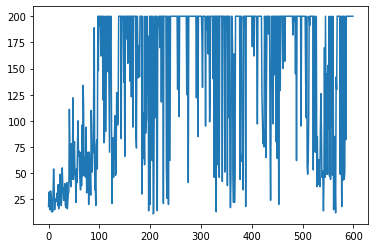

In [4]:
import matplotlib.pyplot as plt
plt.plot(reward_records)